# TO DO

- [ ] re-estimate without buildings constructed in 1979
- [ ] re-estimate with diff census attrs
- [ ] re-estimate w/ + w/o buildings built < 2007
- [ ] check variability of census attrs over time
- [ ] map of eviction data (hexes)
- [ ] redo table 1 by rates across all addresses
- [ ] redo rd plot for pre 2013 evictions and post 2013 evictions
- [ ] subtract evictions in year 2017??

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.formula.api as smf
%matplotlib inline

In [2]:
asr = pd.read_csv('../../../2021_02_summer/evic_paper/data/asr_grouped_by_yr_w_fips.csv', dtype={'fipscd': str})

Only counting evictions after 2007 already

In [3]:
assert (asr['ev_count'] == asr['ev_count_post_07']).all()

In [4]:
asr['any_ev'] = (asr['ev_count'] > 0).astype(int)
asr['pre_1980'] = (asr['year_built_max'] < 1980)
asr['built_1980'] = None
asr.loc[asr['pre_1980'], 'built_1980'] = 'before'
asr.loc[~asr['pre_1980'], 'built_1980'] = 'after'
asr['ev_per_unit'] = asr['ev_count'] / asr['total_units']

In [26]:
ev = pd.read_csv('../../../2021_02_summer/evic_paper/data/ev_matched_w_fips.csv')

In [27]:
ev.shape

(21802, 26)

In [37]:
asr.shape

(1553397, 29)

In [ ]:
# asr_all = pd.read_csv('../data/assessor_2007-2016_fips_jun_2021.csv')
asr_all = pd.read_csv('../data/assessor_2007-2016_fips.csv')

In [ ]:
asr_all.shape

In [41]:
asr_all.shape

(1978687, 52)

Make sure all matched evictions are accounted for in the assessor file and no more

In [28]:
assert len(ev[~pd.isnull(ev['asr_index'])]) == asr['ev_count'].sum()

% evictions matched to assessor records

In [29]:
len(ev[~pd.isnull(ev['asr_index'])]) / len(ev)

0.9235849922025502

In [30]:
ev = ev.merge(asr, left_on='asr_index', right_on='index', suffixes=('_ev', '_asr'))
print(ev.shape)

(20136, 55)


In [31]:
ev = ev[(ev['total_units'] > 0)]
print(ev.shape)

(19199, 55)


In [32]:
ev = ev[(ev['any_rc_eligibility'] == 1)]
print(ev.shape)

(13963, 55)


In [11]:
assert ev['year'].min() == 2007

In [12]:
assert ev['year'].max() == 2016

In [34]:
asr[(asr['total_units'] > 0) & (asr['any_rc_eligibility'] == 1)]

,index,asr_yr,house_1,house_2,street_name,street_type,total_units,uniq_unit_counts,min_units,uniq_bldg_types,...,uniq_parcels,parcel_id,uniq_nbds,nbd_code,ev_count_post_07,ev_count,any_ev,pre_1980,built_1980,ev_per_unit
15,15,2007,-999,0,EARL,ST,3,2,0,2,...,3,4620 001,1,10J,0,0,0,True,before,0.0
50,50,2007,-999,1,ALADDIN,TER,2,1,2,1,...,1,0100 017A,1,08E,0,0,0,True,before,0.0
94,94,2007,-999,1,CABRILLO,ST,23,1,23,1,...,1,1644 034,1,01B,0,0,0,True,before,0.0
112,112,2007,-999,1,CLIPPER,ST,6,1,6,1,...,1,6551 001,1,05C,0,0,0,True,before,0.0
126,126,2007,-999,1,CRESTLINE,DR,12,1,12,1,...,1,2851 022,1,04C,0,0,0,True,before,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553391,1553391,2016,9800,974,HOWARD,ST,24,1,24,1,...,1,3725 103,1,09F,0,0,0,False,after,0.0
1553392,1553392,2016,9800,8400,CARL,ST,6,1,6,1,...,1,1268 026,1,05B,0,0,0,True,before,0.0
1553393,1553393,2016,9870,9830,HAIGHT,ST,9,1,9,1,...,1,1240 024,1,05F,0,0,0,True,before,0.0
1553394,1553394,2016,9880,9860,CLAYTON,ST,2,1,2,1,...,1,1269 050,1,05E,0,0,0,True,before,0.0


#### Table 1

In [14]:
ev.loc[pd.isnull(ev['type']), 'type'] = 'unknown'
type_counts = ev.groupby(['built_1980', 'type']).agg(count=('index_ev', 'nunique')).reset_index()
pre_sums = type_counts.groupby('built_1980')['count'].sum()

ev['ev_type_cat'] = 'breach of lease'
ev.loc[ev['type'].isin([
    'OMI', 'Capital Improvement', 'ELLIS', 'Condo Conversion', 'Substantial Rehabilitation',
    'Lead Remediation', 'Good Samaritan Tenancy Ends',
    'Development Agreement', 'Demolition']), 'ev_type_cat'] = 'no fault'
ev.loc[ev['type'].isin(['unknown', 'Other']), 'ev_type_cat'] = 'unknown/Other'

In [15]:
cat_counts = ev.groupby(['built_1980', 'ev_type_cat']).agg(count=('index_ev', 'nunique')).reset_index()
cat_counts = cat_counts.pivot(index='ev_type_cat', columns='built_1980', values='count')
cat_counts['pct_ev_after'] = cat_counts['after'] / pre_sums['after']
cat_counts['pct_ev_before'] = cat_counts['before'] / pre_sums['before']

In [16]:
cat_counts[['before','pct_ev_before','after','pct_ev_after']]

built_1980,before,pct_ev_before,after,pct_ev_after
ev_type_cat,,,,
breach of lease,6432,0.466967,124,0.656085
no fault,2168,0.157398,3,0.015873
unknown/Other,5174,0.375635,62,0.328042


In [17]:
cat_counts['before'].sum()

13774

In [18]:
cat_counts['after'].sum()

189

In [19]:
13774 + 189

13963

#### Table 2

In [36]:
asr.shape

(1553397, 29)

In [20]:
mean_diffs = asr[
    (asr['total_units'] > 0)].groupby(['any_rc_eligibility', 'pre_1980']).agg(
        total_addresses=('index', 'count'),
        total_units=('total_units', 'sum'),
        mean_units_per_address=('total_units','mean'),
        total_evictions=('ev_count', 'sum'),
        mean_any_ev=('any_ev', 'mean'),
        mean_ev_per_address=('ev_count','mean'),
        mean_ev_per_unit=('ev_per_unit','mean'),
)

# mean_diffs['units_per_address'] = mean_diffs['total_units'] / mean_diffs['total_addresses']
# mean_diffs['evictions_per_address'] = mean_diffs['total_evictions'] / mean_diffs['total_addresses']
# mean_diffs['evictions_per_unit'] = mean_diffs['total_evictions'] / mean_diffs['total_units']

mean_diffs

total_addresses  total_units  \
any_rc_eligibility pre_1980                                 
0.0                False               70104       331191   
                   True              1020259      1445753   
1.0                False               14132       114759   
                   True               330381      1591854   

                             mean_units_per_address  total_evictions  \
any_rc_eligibility pre_1980                                            
0.0                False                   4.724281              243   
                   True                    1.417045             4993   
1.0                False                   8.120507              189   
                   True                    4.818237            13774   

                             mean_any_ev  mean_ev_per_address  \
any_rc_eligibility pre_1980                                     
0.0                False        0.002054             0.003466   
                   True         0.003060             0.004894   
1.0                False        0.006369             0.013374   
                   True         0.019375             0.041691   

                             mean_ev_per_unit  
any_rc_eligibility pre_1980                    
0.0                False             0.001604  
                   True              0.003940  
1.0                False             0.005447  
                   True              0.013095

In [35]:
mean_diffs['total_addresses'].sum()

1434876

#### Fig 1

In [21]:
rc_pop = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1953) &
    (asr['year_built_max'] < 2007) & (asr['total_units'] > 0)]

yr_vs_ev = rc_pop.groupby('year_built_max').agg({
    'ev_per_unit': 'mean',
}).reset_index()

yr_vs_ev1 = yr_vs_ev[(yr_vs_ev['year_built_max'] < 1980) &
                     (yr_vs_ev['year_built_max'] >= 1953)]
yr_vs_ev2 = yr_vs_ev[(yr_vs_ev['year_built_max'] >= 1980) &
                     (yr_vs_ev['year_built_max'] <= 2007)]

In [22]:
rc_pop.shape

(54388, 29)

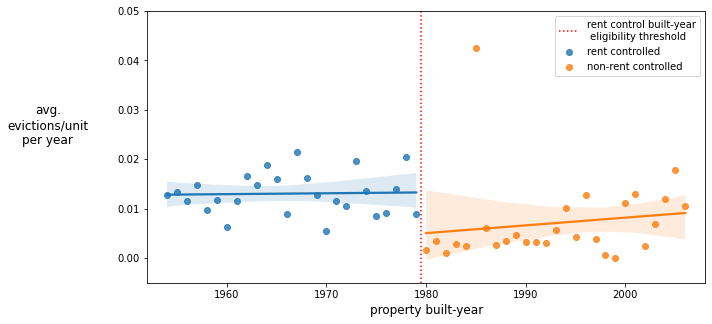

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(x='year_built_max', y='ev_per_unit', data=yr_vs_ev1, ax=ax, truncate=True, label='rent controlled')
sns.regplot(x='year_built_max', y='ev_per_unit', data=yr_vs_ev2, ax=ax, truncate=True, label='non-rent controlled')
ax.axvline(1979.5, ls=':', c='r', label='rent control built-year\n eligibility threshold')
ax.legend()
_ = ax.set_xlabel("property built-year", fontsize=12)
_ = ax.set_ylabel("avg.\nevictions/unit\nper year", fontsize=12, rotation=0, labelpad=70)
# _ = ax.set_title("SF Eviction Rates (2007-2016)\nfor Multi-family Residential Addresses", fontsize=20)
ax.set_ylim((-0.005, 0.05))
ax.set_xlim((1952, 2008))
# ax.annotate('rent control \nbuilt-year threshold', xy=(1979, 0.04),  xycoords='data',
#             xytext=(0.3, 0.8), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black',headlength=10, width=0.5, headwidth=10),
#             horizontalalignment='center', verticalalignment='center', fontsize=12
#             )
plt.savefig('../../../2021_02_summer/evic_paper/fig_1.jpg', dpi=300, bbox_inches='tight')

#### Fig 2

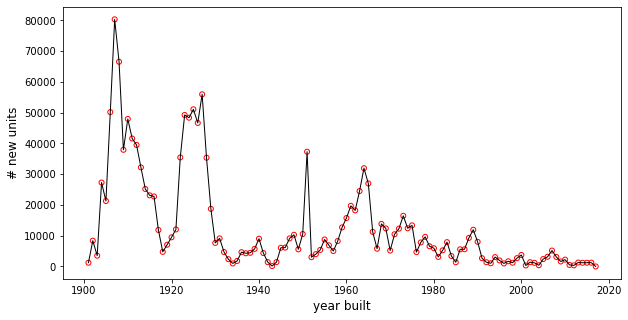

In [68]:
units_by_yr = asr[
    (asr['any_rc_eligibility'] == 1) &
    (asr['year_built_max'] > 1900) &
    (asr['year_built_max'] < 2100)].groupby('year_built_max').agg({'total_units': 'sum'}).reset_index()

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(units_by_yr['year_built_max'], units_by_yr['total_units'], s=25, facecolors='none', edgecolors='r')
ax.plot(units_by_yr['year_built_max'], units_by_yr['total_units'], lw=1, c='k', )

_ = ax.set_xlabel("year built", fontsize=12)
_ = ax.set_ylabel("# new units", fontsize=12)
# _ = ax.set_title("SF New Construction: Rent-control eligible use-codes", fontsize=20)

plt.savefig('../../../2021_02_summer/evic_paper/fig_2.jpg', dpi=300, bbox_inches='tight')

#### Fig 3

In [70]:
sf = gpd.read_file('../../../2021_02_summer/evic_paper/sf_boundary.shp')

In [87]:
asr_all = pd.read_csv('../data/assessor_2007-2016_fips_jun_2021.csv')

/Users/max/anaconda3/envs/evictions/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2,8,11,17,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [90]:
asr_all['geometry'] = asr_all.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)

In [92]:
asr_all = gpd.GeoDataFrame(asr_all, geometry='geometry')

In [94]:
asr_all.head()

,Unnamed: 0,BASELOT,BASELOTSFX,BATHS,BEDS,BUILTIN,CONSTTYPE,DEPTH,EXEMPTYPE,FBA,...,street_name,street_rest,street_type,unit_num,bldg_type,Parcel Number,GEOID,latitude,longitude,geometry
0,0,NaN,NaN,0,0,NaN,NaN,0.0,NaN,0.0,...,JEFFERSON,ST0000,ST,0000,4.0,0005001,60750101001000,37.808403,-122.416680,POINT (-122.41668 37.80840)
1,1,NaN,NaN,0,0,NaN,C,0.0,NaN,0.0,...,LEAVENWORTH,ST0000,ST,0000,5.0,0010001,60750102001006,37.807271,-122.419477,POINT (-122.41948 37.80727)
2,2,NaN,NaN,0,0,NaN,NaN,0.0,NaN,0.0,...,JEFFERSON,ST0000,ST,0000,7.0,0010002,60750102001006,37.807188,-122.420129,POINT (-122.42013 37.80719)
3,3,NaN,NaN,0,0,NaN,NaN,75.0,NaN,0.0,...,LEAVENWORTH,ST0000,ST,0000,7.0,0011007,60750101001007,37.807389,-122.418539,POINT (-122.41854 37.80739)
4,4,NaN,NaN,7,0,NaN,A,75.0,NaN,0.0,...,BEACH,ST0000,ST,0000,5.0,0011008,60750101001007,37.807479,-122.417829,POINT (-122.41783 37.80748)


In [95]:
asr.head()

,index,asr_yr,house_1,house_2,street_name,street_type,total_units,uniq_unit_counts,min_units,uniq_bldg_types,...,uniq_parcels,parcel_id,uniq_nbds,nbd_code,ev_count_post_07,ev_count,any_ev,pre_1980,built_1980,ev_per_unit
0,0,2007,-999,0,10TH,ST,0,1,0,1,...,1,3518 039,1,09F,0,0,0,True,before,NaN
1,1,2007,-999,0,19TH,AVE,0,1,0,1,...,1,7231 019A,1,03E,0,0,0,True,before,NaN
2,2,2007,-999,0,2919 INGALLS,ST,0,1,0,1,...,1,4938 034,1,10A,0,0,0,False,after,NaN
3,3,2007,-999,0,6TH,ST,0,1,0,1,...,1,3704 049,1,09F,0,0,0,True,before,NaN
4,4,2007,-999,0,ALABAMA,ST,0,1,0,1,...,1,4271 043,1,09C,0,0,0,True,before,NaN


In [75]:
ev[['latitude','longitude']].isna().any()

latitude     False
longitude    False
dtype: bool

In [79]:
ev['geometry'] = ev.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)

In [81]:
ev_gpd = gpd.GeoDataFrame(ev, geometry='geometry')

<AxesSubplot:>

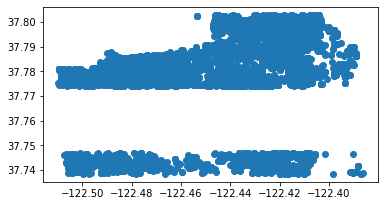

In [82]:
ev_gpd.plot()

<AxesSubplot:>

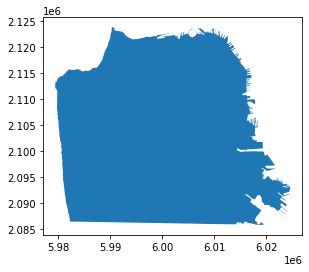

In [71]:
sf.plot()

# RD 

In [7]:
bandwidth = 27

df = asr[
    (asr['any_rc_eligibility'] == 1) & (asr['year_built_max'] > 1980 - bandwidth) &
    (asr['year_built_max'] < 1980 + bandwidth) & (asr['total_units'] > 0)]

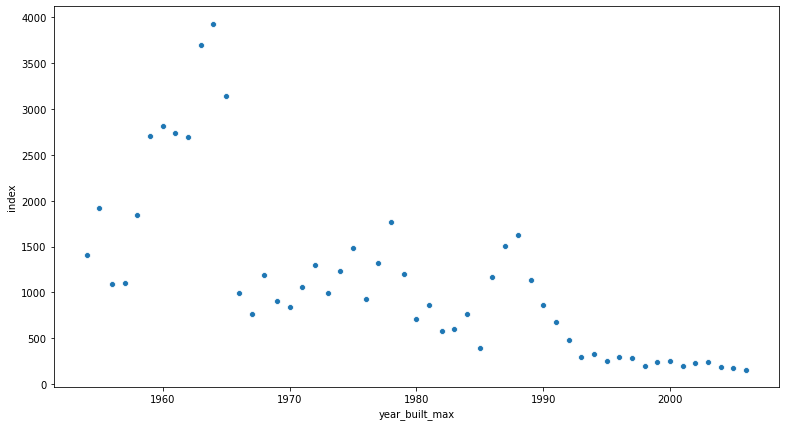

In [12]:
fig, ax = plt.subplots(figsize=(13,7))
foo = df.groupby('year_built_max').count()['index']
sns.scatterplot(foo.index, foo, ax=ax)

In [10]:
df.groupby('year_built_max').count()

,index,asr_yr,house_1,house_2,street_name,street_type,total_units,uniq_unit_counts,min_units,uniq_bldg_types,...,uniq_fipscd,fipscd,ev_count_post_07,ev_count,any_ev,any_ev_07,pre_1980,built_1980,ev_per_unit,ev_per_unit_since_07
year_built_max,,,,,,,,,,,,,,,,,,,,,
1954,1412,1412,1412,1412,1412,1412,1412,1412,1412,1412,...,1412,1412,1412,1412,1412,1412,1412,1412,1412,1412
1955,1916,1916,1916,1916,1916,1916,1916,1916,1916,1916,...,1916,1916,1916,1916,1916,1916,1916,1916,1916,1916
1956,1087,1087,1087,1087,1087,1087,1087,1087,1087,1087,...,1087,1087,1087,1087,1087,1087,1087,1087,1087,1087
1957,1104,1104,1104,1104,1104,1104,1104,1104,1104,1104,...,1104,1104,1104,1104,1104,1104,1104,1104,1104,1104
1958,1847,1847,1847,1847,1847,1847,1847,1847,1847,1847,...,1847,1847,1847,1847,1847,1847,1847,1847,1847,1847
1959,2705,2705,2705,2705,2705,2705,2705,2705,2705,2705,...,2705,2705,2705,2705,2705,2705,2705,2705,2705,2705
1960,2815,2815,2815,2815,2815,2815,2815,2815,2815,2815,...,2815,2815,2815,2815,2815,2815,2815,2815,2815,2815
1961,2735,2735,2735,2735,2735,2735,2735,2735,2735,2735,...,2735,2735,2735,2735,2735,2735,2735,2735,2735,2735
1962,2695,2695,2695,2695,2695,2695,2695,2695,2695,2695,...,2695,2695,2695,2695,2695,2695,2695,2695,2695,2695
